In [5]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

from collections import defaultdict

# Data Preparation

In [6]:
class_name = 'Occupancy'
df_training = pd.read_csv('training.csv', skipinitialspace=True, na_values='?', keep_default_na=True)
df_test = pd.read_csv('test.csv', skipinitialspace=True, na_values='?', keep_default_na=True)

weekend_train = df_training['weekend']
weekend_test = df_test['weekend']
columns2remove = ['date', 'Unnamed: 0', 'cumulative_hour', 'cumulative_minute', 'day', 'weekend', 'day_minute', 'minute', 'hour']
df_training.drop(columns2remove, inplace=True, axis=1)
df_test.drop(columns2remove, inplace=True, axis=1)
df_training.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,23.7000,26.272,585.200000,749.200000,0.004764,1
1,23.7180,26.290,578.400000,760.400000,0.004773,1
2,23.7300,26.230,572.666667,769.666667,0.004765,1
3,23.7225,26.125,493.750000,774.750000,0.004744,1
4,23.7540,26.200,488.600000,779.000000,0.004767,1


# Data Partitioning

In [7]:
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [8]:
attributes = [col for col in df_training.columns if col != class_name]

X_train = df_training[attributes].values
y_train = df_training[class_name]

X_test = df_test[attributes].values
y_test = df_test[class_name]

# Normalization

In [9]:
from sklearn.preprocessing import StandardScaler

In [10]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
#Unisco training e test perche' fra un po' Guidotti usa X e y, numpy array prima dello split
#frames = [df_training, df_test]

#result = pd.concat(frames)

#attributes = [col for col in df_training.columns if col != class_name]
#X = result[attributes].values
#y = result[class_name]

# Sklearn Multilayer Perceptron

In [12]:
from sklearn.neural_network import MLPClassifier

### Parameters

hidden_layer_sizes tuple, length = n_layers - 2, default=(100,)
The ith element represents the number of neurons in the ith hidden layer.

activation {'identity', 'logistic', 'tanh', 'relu'}, default='relu'
Activation function for the hidden layer.
* 'identity', no-op activation, useful to implement linear bottleneck, returns f(x) = x
* 'logistic', the logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x)).
* 'tanh', the hyperbolic tan function, returns f(x) = tanh(x).
* 'relu', the rectified linear unit function, returns f(x) = max(0, x)

solver {'lbfgs', 'sgd', 'adam'}, default='adam'
The solver for weight optimization.
* 'lbfgs' is an optimizer in the family of quasi-Newton methods.
* 'sgd' refers to stochastic gradient descent.
* 'adam' refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy Ba
The default solver 'adam' works pretty well on relatively large datasets (>= 1000 training samples) in terms of both training time and validation score. For small datasets, 'lbfgs' can converge faster and perform better.

alpha float, default=0.0001
L2 penalty (regularization term) parameter.

batch_size int, default='auto'
Size of minibatches for stochastic optimizers. If the solver is 'lbfgs', the classifier will not use minibatch. When set to “auto”, batch_size=min(200, n_samples)

learning_rate {'constant', 'invscaling', 'adaptive'}, default='constant'
Learning rate schedule for weight updates.
*'constant' is a constant learning rate given by 'learning_rate_init'.
*'invscaling' gradually decreases the learning rate at each time step 't' using an inverse scaling exponent of *'power_t'. effective_learning_rate = learning_rate_init / pow(t, power_t)
*'adaptive' keeps the learning rate constant to 'learning_rate_init' as long as training loss keeps decreasing. Each time two consecutive epochs fail to decrease training loss by at least tol, or fail to increase validation score by at least tol if 'early_stopping' is on, the current learning rate is divided by 5.
Only used when solver='sgd'.

learning_rate_init double, default=0.001
The initial learning rate used. It controls the step-size in updating the weights. Only used when solver='sgd' or 'adam'.

power_t double, default=0.5
The exponent for inverse scaling learning rate. It is used in updating effective learning rate when the learning_rate is set to 'invscaling'. Only used when solver='sgd'.

max_iter int, default=200
Maximum number of iterations. The solver iterates until convergence (determined by 'tol') or this number of iterations. For stochastic solvers ('sgd', 'adam'), note that this determines the number of epochs (how many times each data point will be used), not the number of gradient steps.

shuffle bool, default=True
Whether to shuffle samples in each iteration. Only used when solver='sgd' or 'adam'.

random_state int, RandomState instance or None, default=None
If int, random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random.

tol float, default=1e-4
Tolerance for the optimization. When the loss or score is not improving by at least tol for n_iter_no_change consecutive iterations, unless learning_rate is set to 'adaptive', convergence is considered to be reached and training stops.

verbose bool, default=False
Whether to print progress messages to stdout.

warm_start bool, default=False
When set to True, reuse the solution of the previous call to fit as initialization, otherwise, just erase the previous solution. See the Glossary.

momentum float, default=0.9
Momentum for gradient descent update. Should be between 0 and 1. Only used when solver='sgd'.

early_stopping bool, default=False
Whether to use early stopping to terminate training when validation score is not improving. If set to true, it will automatically set aside 10% of training data as validation and terminate training when validation score is not improving by at least tol for n_iter_no_change consecutive epochs. The split is stratified, except in a multilabel setting. Only effective when solver='sgd' or 'adam'

validation_fraction float, default=0.1
The proportion of training data to set aside as validation set for early stopping. Must be between 0 and 1. Only used if early_stopping is True

beta_1 float, default=0.9
Exponential decay rate for estimates of first moment vector in adam, should be in [0, 1). Only used when solver='adam'

beta_2 float, default=0.999
Exponential decay rate for estimates of second moment vector in adam, should be in [0, 1). Only used when solver='adam'

epsilon float, default=1e-8
Value for numerical stability in adam. Only used when solver='adam'

n_iter_no_change int, default=10
Maximum number of epochs to not meet tol improvement. Only effective when solver='sgd' or 'adam'


### Attributes
loss_ float
The current loss computed with the loss function.

coefs_ list, length n_layers - 1
The ith element in the list represents the weight matrix corresponding to layer i.

intercepts_ list, length n_layers - 1
The ith element in the list represents the bias vector corresponding to layer i + 1.

n_iter_ int,
The number of iterations the solver has ran.

n_layers_ int
Number of layers.

n_outputs_ int
Number of outputs.

out_activation_ string
Name of the output activation function.

In [9]:
help(MLPClassifier)

Help on class MLPClassifier in module sklearn.neural_network._multilayer_perceptron:

class MLPClassifier(sklearn.base.ClassifierMixin, BaseMultilayerPerceptron)
 |  MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, max_fun=15000)
 |  
 |  Multi-layer Perceptron classifier.
 |  
 |  This model optimizes the log-loss function using LBFGS or stochastic
 |  gradient descent.
 |  
 |  .. versionadded:: 0.18
 |  
 |  Parameters
 |  ----------
 |  hidden_layer_sizes : tuple, length = n_layers - 2, default=(100,)
 |      The ith element represents the number of neurons in the ith
 |      hidden layer.
 |  
 |  activation : {'identity', 

In [10]:
clf = MLPClassifier(hidden_layer_sizes=(128, 64, 32,), alpha=0.1, learning_rate='adaptive', 
                    activation='tanh', early_stopping=False, momentum=0.9, random_state=0) #Unico random state della cella

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9828145265888456
F1-score [0.98944013 0.95387293]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      5071
           1       0.91      1.00      0.95      1097

    accuracy                           0.98      6168
   macro avg       0.96      0.99      0.97      6168
weighted avg       0.98      0.98      0.98      6168



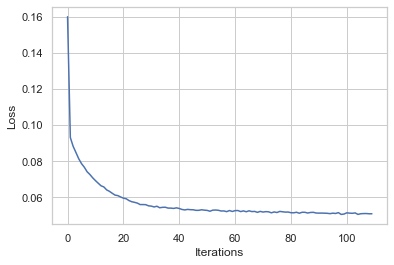

In [11]:
plt.plot(clf.loss_curve_)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [14]:
%%time
from collections import OrderedDict
import warnings
from sklearn.exceptions import ConvergenceWarning
from itertools import product

activation = ['identity', 'logistic', 'tanh', 'relu']
hidden_layer_sizes = [(50,), (100,), 
                      (50, 100,), (50, 150,),
                     (50, 100, 150,), (50, 100, 200,)]
solver = ['lbfgs', 'sgd', 'adam']
learning_rate = ['constant', 'invscaling', 'adaptive']
momentum = [0, 0.3, 0.6, 0.9]
random_state = [0, 1, 2, 3, 4]
# aggiungere ai parametri un range di random state

seq = product(activation, hidden_layer_sizes, solver, learning_rate, momentum, random_state)

params = []

for item in seq:
    d = {}
    d['activation'] = item[0]
    d['hidden_layer_sizes'] = item[1]
    d['solver'] = item[2]
    d['learning_rate'] = item[3]
    d['momentum'] = item[4]
    d['random_state'] = item[5]
    params.append(d)

labels = list(range(len(params)))

summary = []

for label, param in zip(labels, params):
    print('----------------------ITERAZIONE', label + 1, 'DI 4320-------------------------' )
    #for key in param:
    #    print(key, '=', param[key])
    clf = MLPClassifier(max_iter=200, **param)

    # some parameter combinations will not converge as can be seen on the
    # plots so they are ignored here
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
        clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    
    #print('Accuracy %s' % accuracy_score(y_test, y_pred))
    #print('F1-score %s' % f1_score(y_test, y_pred, average=None))
    #print(classification_report(y_test, y_pred))
        
    #print("training set score and loss: %.3f, %f" % (clf.score(X_train, y_train), clf.loss_))
    #plt.plot(clf.loss_curve_, label=label)
    #plt.legend(loc="upper center")
    #plt.show()
    
    report = classification_report(y_test, y_pred, output_dict=True)

    summary.append({'label' : label,
                    'params' : param,
                    'training_accuracy' : clf.score(X_train, y_train), 
                    'loss' : clf.loss_,
                    'test_accuracy' : accuracy_score(y_test, y_pred),
                    'f1-score [0]' : f1_score(y_test, y_pred, average=None)[0],
                    'f1-score [1]' : f1_score(y_test, y_pred, average=None)[1],
                    'precision [1]' : report['1']['precision'],
                    'recall [1]' : report['1']['recall']})
    


----------------------ITERAZIONE 1 DI 4320-------------------------
----------------------ITERAZIONE 2 DI 4320-------------------------
----------------------ITERAZIONE 3 DI 4320-------------------------
----------------------ITERAZIONE 4 DI 4320-------------------------
----------------------ITERAZIONE 5 DI 4320-------------------------
----------------------ITERAZIONE 6 DI 4320-------------------------
----------------------ITERAZIONE 7 DI 4320-------------------------
----------------------ITERAZIONE 8 DI 4320-------------------------
----------------------ITERAZIONE 9 DI 4320-------------------------
----------------------ITERAZIONE 10 DI 4320-------------------------
----------------------ITERAZIONE 11 DI 4320-------------------------
----------------------ITERAZIONE 12 DI 4320-------------------------
----------------------ITERAZIONE 13 DI 4320-------------------------
----------------------ITERAZIONE 14 DI 4320-------------------------
----------------------ITERAZIONE 15 DI 4320

C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 85 DI 4320-------------------------
----------------------ITERAZIONE 86 DI 4320-------------------------
----------------------ITERAZIONE 87 DI 4320-------------------------
----------------------ITERAZIONE 88 DI 4320-------------------------
----------------------ITERAZIONE 89 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 90 DI 4320-------------------------
----------------------ITERAZIONE 91 DI 4320-------------------------
----------------------ITERAZIONE 92 DI 4320-------------------------
----------------------ITERAZIONE 93 DI 4320-------------------------
----------------------ITERAZIONE 94 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 95 DI 4320-------------------------
----------------------ITERAZIONE 96 DI 4320-------------------------
----------------------ITERAZIONE 97 DI 4320-------------------------
----------------------ITERAZIONE 98 DI 4320-------------------------
----------------------ITERAZIONE 99 DI 4320-------------------------
----------------------ITERAZIONE 100 DI 4320-------------------------
----------------------ITERAZIONE 101 DI 4320-------------------------
----------------------ITERAZIONE 102 DI 4320-------------------------
----------------------ITERAZIONE 103 DI 4320-------------------------
----------------------ITERAZIONE 104 DI 4320-------------------------
----------------------ITERAZIONE 105 DI 4320-------------------------
----------------------ITERAZIONE 106 DI 4320-------------------------
----------------------ITERAZIONE 107 DI 4320-------------------------
----------------------ITERAZIONE 108 DI 4320-------------------------
----------------------ITE

----------------------ITERAZIONE 330 DI 4320-------------------------
----------------------ITERAZIONE 331 DI 4320-------------------------
----------------------ITERAZIONE 332 DI 4320-------------------------
----------------------ITERAZIONE 333 DI 4320-------------------------
----------------------ITERAZIONE 334 DI 4320-------------------------
----------------------ITERAZIONE 335 DI 4320-------------------------
----------------------ITERAZIONE 336 DI 4320-------------------------
----------------------ITERAZIONE 337 DI 4320-------------------------
----------------------ITERAZIONE 338 DI 4320-------------------------
----------------------ITERAZIONE 339 DI 4320-------------------------
----------------------ITERAZIONE 340 DI 4320-------------------------
----------------------ITERAZIONE 341 DI 4320-------------------------
----------------------ITERAZIONE 342 DI 4320-------------------------
----------------------ITERAZIONE 343 DI 4320-------------------------
--------------------

----------------------ITERAZIONE 448 DI 4320-------------------------
----------------------ITERAZIONE 449 DI 4320-------------------------
----------------------ITERAZIONE 450 DI 4320-------------------------
----------------------ITERAZIONE 451 DI 4320-------------------------
----------------------ITERAZIONE 452 DI 4320-------------------------
----------------------ITERAZIONE 453 DI 4320-------------------------
----------------------ITERAZIONE 454 DI 4320-------------------------
----------------------ITERAZIONE 455 DI 4320-------------------------
----------------------ITERAZIONE 456 DI 4320-------------------------
----------------------ITERAZIONE 457 DI 4320-------------------------
----------------------ITERAZIONE 458 DI 4320-------------------------
----------------------ITERAZIONE 459 DI 4320-------------------------
----------------------ITERAZIONE 460 DI 4320-------------------------
----------------------ITERAZIONE 461 DI 4320-------------------------
--------------------

----------------------ITERAZIONE 566 DI 4320-------------------------
----------------------ITERAZIONE 567 DI 4320-------------------------
----------------------ITERAZIONE 568 DI 4320-------------------------
----------------------ITERAZIONE 569 DI 4320-------------------------
----------------------ITERAZIONE 570 DI 4320-------------------------
----------------------ITERAZIONE 571 DI 4320-------------------------
----------------------ITERAZIONE 572 DI 4320-------------------------
----------------------ITERAZIONE 573 DI 4320-------------------------
----------------------ITERAZIONE 574 DI 4320-------------------------
----------------------ITERAZIONE 575 DI 4320-------------------------
----------------------ITERAZIONE 576 DI 4320-------------------------
----------------------ITERAZIONE 577 DI 4320-------------------------
----------------------ITERAZIONE 578 DI 4320-------------------------
----------------------ITERAZIONE 579 DI 4320-------------------------
--------------------

----------------------ITERAZIONE 684 DI 4320-------------------------
----------------------ITERAZIONE 685 DI 4320-------------------------
----------------------ITERAZIONE 686 DI 4320-------------------------
----------------------ITERAZIONE 687 DI 4320-------------------------
----------------------ITERAZIONE 688 DI 4320-------------------------
----------------------ITERAZIONE 689 DI 4320-------------------------
----------------------ITERAZIONE 690 DI 4320-------------------------
----------------------ITERAZIONE 691 DI 4320-------------------------
----------------------ITERAZIONE 692 DI 4320-------------------------
----------------------ITERAZIONE 693 DI 4320-------------------------
----------------------ITERAZIONE 694 DI 4320-------------------------
----------------------ITERAZIONE 695 DI 4320-------------------------
----------------------ITERAZIONE 696 DI 4320-------------------------
----------------------ITERAZIONE 697 DI 4320-------------------------
--------------------

----------------------ITERAZIONE 802 DI 4320-------------------------
----------------------ITERAZIONE 803 DI 4320-------------------------
----------------------ITERAZIONE 804 DI 4320-------------------------
----------------------ITERAZIONE 805 DI 4320-------------------------
----------------------ITERAZIONE 806 DI 4320-------------------------
----------------------ITERAZIONE 807 DI 4320-------------------------
----------------------ITERAZIONE 808 DI 4320-------------------------
----------------------ITERAZIONE 809 DI 4320-------------------------
----------------------ITERAZIONE 810 DI 4320-------------------------
----------------------ITERAZIONE 811 DI 4320-------------------------
----------------------ITERAZIONE 812 DI 4320-------------------------
----------------------ITERAZIONE 813 DI 4320-------------------------
----------------------ITERAZIONE 814 DI 4320-------------------------
----------------------ITERAZIONE 815 DI 4320-------------------------
--------------------

----------------------ITERAZIONE 920 DI 4320-------------------------
----------------------ITERAZIONE 921 DI 4320-------------------------
----------------------ITERAZIONE 922 DI 4320-------------------------
----------------------ITERAZIONE 923 DI 4320-------------------------
----------------------ITERAZIONE 924 DI 4320-------------------------
----------------------ITERAZIONE 925 DI 4320-------------------------
----------------------ITERAZIONE 926 DI 4320-------------------------
----------------------ITERAZIONE 927 DI 4320-------------------------
----------------------ITERAZIONE 928 DI 4320-------------------------
----------------------ITERAZIONE 929 DI 4320-------------------------
----------------------ITERAZIONE 930 DI 4320-------------------------
----------------------ITERAZIONE 931 DI 4320-------------------------
----------------------ITERAZIONE 932 DI 4320-------------------------
----------------------ITERAZIONE 933 DI 4320-------------------------
--------------------

----------------------ITERAZIONE 1037 DI 4320-------------------------
----------------------ITERAZIONE 1038 DI 4320-------------------------
----------------------ITERAZIONE 1039 DI 4320-------------------------
----------------------ITERAZIONE 1040 DI 4320-------------------------
----------------------ITERAZIONE 1041 DI 4320-------------------------
----------------------ITERAZIONE 1042 DI 4320-------------------------
----------------------ITERAZIONE 1043 DI 4320-------------------------
----------------------ITERAZIONE 1044 DI 4320-------------------------
----------------------ITERAZIONE 1045 DI 4320-------------------------
----------------------ITERAZIONE 1046 DI 4320-------------------------
----------------------ITERAZIONE 1047 DI 4320-------------------------
----------------------ITERAZIONE 1048 DI 4320-------------------------
----------------------ITERAZIONE 1049 DI 4320-------------------------
----------------------ITERAZIONE 1050 DI 4320-------------------------
------

----------------------ITERAZIONE 1153 DI 4320-------------------------
----------------------ITERAZIONE 1154 DI 4320-------------------------
----------------------ITERAZIONE 1155 DI 4320-------------------------
----------------------ITERAZIONE 1156 DI 4320-------------------------
----------------------ITERAZIONE 1157 DI 4320-------------------------
----------------------ITERAZIONE 1158 DI 4320-------------------------
----------------------ITERAZIONE 1159 DI 4320-------------------------
----------------------ITERAZIONE 1160 DI 4320-------------------------
----------------------ITERAZIONE 1161 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1162 DI 4320-------------------------
----------------------ITERAZIONE 1163 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1164 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1165 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1166 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1167 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1168 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1169 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1170 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1171 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1172 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1173 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1174 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1175 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1176 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1177 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1178 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1179 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1180 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1181 DI 4320-------------------------
----------------------ITERAZIONE 1182 DI 4320-------------------------
----------------------ITERAZIONE 1183 DI 4320-------------------------
----------------------ITERAZIONE 1184 DI 4320-------------------------
----------------------ITERAZIONE 1185 DI 4320-------------------------
----------------------ITERAZIONE 1186 DI 4320-------------------------
----------------------ITERAZIONE 1187 DI 4320-------------------------
----------------------ITERAZIONE 1188 DI 4320-------------------------
----------------------ITERAZIONE 1189 DI 4320-------------------------
----------------------ITERAZIONE 1190 DI 4320-------------------------
----------------------ITERAZIONE 1191 DI 4320-------------------------
----------------------ITERAZIONE 1192 DI 4320-------------------------
----------------------ITERAZIONE 1193 DI 4320-------------------------
----------------------ITERAZIONE 1194 DI 4320-------------------------
------

----------------------ITERAZIONE 1297 DI 4320-------------------------
----------------------ITERAZIONE 1298 DI 4320-------------------------
----------------------ITERAZIONE 1299 DI 4320-------------------------
----------------------ITERAZIONE 1300 DI 4320-------------------------
----------------------ITERAZIONE 1301 DI 4320-------------------------
----------------------ITERAZIONE 1302 DI 4320-------------------------
----------------------ITERAZIONE 1303 DI 4320-------------------------
----------------------ITERAZIONE 1304 DI 4320-------------------------
----------------------ITERAZIONE 1305 DI 4320-------------------------
----------------------ITERAZIONE 1306 DI 4320-------------------------
----------------------ITERAZIONE 1307 DI 4320-------------------------
----------------------ITERAZIONE 1308 DI 4320-------------------------
----------------------ITERAZIONE 1309 DI 4320-------------------------
----------------------ITERAZIONE 1310 DI 4320-------------------------
------

C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1342 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1343 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1344 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1345 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1346 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1347 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1348 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1349 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1350 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1351 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1352 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1353 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1354 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1355 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1356 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1357 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1358 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1359 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1360 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1361 DI 4320-------------------------
----------------------ITERAZIONE 1362 DI 4320-------------------------
----------------------ITERAZIONE 1363 DI 4320-------------------------
----------------------ITERAZIONE 1364 DI 4320-------------------------
----------------------ITERAZIONE 1365 DI 4320-------------------------
----------------------ITERAZIONE 1366 DI 4320-------------------------
----------------------ITERAZIONE 1367 DI 4320-------------------------
----------------------ITERAZIONE 1368 DI 4320-------------------------
----------------------ITERAZIONE 1369 DI 4320-------------------------
----------------------ITERAZIONE 1370 DI 4320-------------------------
----------------------ITERAZIONE 1371 DI 4320-------------------------
----------------------ITERAZIONE 1372 DI 4320-------------------------
----------------------ITERAZIONE 1373 DI 4320-------------------------
----------------------ITERAZIONE 1374 DI 4320-------------------------
------

----------------------ITERAZIONE 1477 DI 4320-------------------------
----------------------ITERAZIONE 1478 DI 4320-------------------------
----------------------ITERAZIONE 1479 DI 4320-------------------------
----------------------ITERAZIONE 1480 DI 4320-------------------------
----------------------ITERAZIONE 1481 DI 4320-------------------------
----------------------ITERAZIONE 1482 DI 4320-------------------------
----------------------ITERAZIONE 1483 DI 4320-------------------------
----------------------ITERAZIONE 1484 DI 4320-------------------------
----------------------ITERAZIONE 1485 DI 4320-------------------------
----------------------ITERAZIONE 1486 DI 4320-------------------------
----------------------ITERAZIONE 1487 DI 4320-------------------------
----------------------ITERAZIONE 1488 DI 4320-------------------------
----------------------ITERAZIONE 1489 DI 4320-------------------------
----------------------ITERAZIONE 1490 DI 4320-------------------------
------

C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1502 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1503 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1504 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1505 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1506 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1507 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1508 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1509 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1510 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1511 DI 4320-------------------------
----------------------ITERAZIONE 1512 DI 4320-------------------------
----------------------ITERAZIONE 1513 DI 4320-------------------------
----------------------ITERAZIONE 1514 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1515 DI 4320-------------------------
----------------------ITERAZIONE 1516 DI 4320-------------------------
----------------------ITERAZIONE 1517 DI 4320-------------------------
----------------------ITERAZIONE 1518 DI 4320-------------------------
----------------------ITERAZIONE 1519 DI 4320-------------------------
----------------------ITERAZIONE 1520 DI 4320-------------------------
----------------------ITERAZIONE 1521 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1522 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1523 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1524 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1525 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1526 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1527 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1528 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1529 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1530 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1531 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1532 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1533 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1534 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1535 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1536 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1537 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1538 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1539 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1540 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1541 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1542 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1543 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1544 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1545 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1546 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1547 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1548 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1549 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1550 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1551 DI 4320-------------------------
----------------------ITERAZIONE 1552 DI 4320-------------------------
----------------------ITERAZIONE 1553 DI 4320-------------------------
----------------------ITERAZIONE 1554 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1555 DI 4320-------------------------
----------------------ITERAZIONE 1556 DI 4320-------------------------
----------------------ITERAZIONE 1557 DI 4320-------------------------
----------------------ITERAZIONE 1558 DI 4320-------------------------
----------------------ITERAZIONE 1559 DI 4320-------------------------
----------------------ITERAZIONE 1560 DI 4320-------------------------
----------------------ITERAZIONE 1561 DI 4320-------------------------
----------------------ITERAZIONE 1562 DI 4320-------------------------
----------------------ITERAZIONE 1563 DI 4320-------------------------
----------------------ITERAZIONE 1564 DI 4320-------------------------
----------------------ITERAZIONE 1565 DI 4320-------------------------
----------------------ITERAZIONE 1566 DI 4320-------------------------
----------------------ITERAZIONE 1567 DI 4320-------------------------
----------------------ITERAZIONE 1568 DI 4320-------------------------
------

----------------------ITERAZIONE 1671 DI 4320-------------------------
----------------------ITERAZIONE 1672 DI 4320-------------------------
----------------------ITERAZIONE 1673 DI 4320-------------------------
----------------------ITERAZIONE 1674 DI 4320-------------------------
----------------------ITERAZIONE 1675 DI 4320-------------------------
----------------------ITERAZIONE 1676 DI 4320-------------------------
----------------------ITERAZIONE 1677 DI 4320-------------------------
----------------------ITERAZIONE 1678 DI 4320-------------------------
----------------------ITERAZIONE 1679 DI 4320-------------------------
----------------------ITERAZIONE 1680 DI 4320-------------------------
----------------------ITERAZIONE 1681 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1682 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1683 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1684 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1685 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1686 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1687 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1688 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1689 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1690 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1691 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1692 DI 4320-------------------------
----------------------ITERAZIONE 1693 DI 4320-------------------------
----------------------ITERAZIONE 1694 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1695 DI 4320-------------------------
----------------------ITERAZIONE 1696 DI 4320-------------------------
----------------------ITERAZIONE 1697 DI 4320-------------------------
----------------------ITERAZIONE 1698 DI 4320-------------------------
----------------------ITERAZIONE 1699 DI 4320-------------------------
----------------------ITERAZIONE 1700 DI 4320-------------------------
----------------------ITERAZIONE 1701 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1702 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1703 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1704 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1705 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1706 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1707 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1708 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1709 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1710 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1711 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1712 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1713 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1714 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1715 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1716 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1717 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1718 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1719 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1720 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1721 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1722 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1723 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1724 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1725 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1726 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1727 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1728 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1729 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1730 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1731 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1732 DI 4320-------------------------
----------------------ITERAZIONE 1733 DI 4320-------------------------
----------------------ITERAZIONE 1734 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1735 DI 4320-------------------------
----------------------ITERAZIONE 1736 DI 4320-------------------------
----------------------ITERAZIONE 1737 DI 4320-------------------------
----------------------ITERAZIONE 1738 DI 4320-------------------------
----------------------ITERAZIONE 1739 DI 4320-------------------------
----------------------ITERAZIONE 1740 DI 4320-------------------------
----------------------ITERAZIONE 1741 DI 4320-------------------------
----------------------ITERAZIONE 1742 DI 4320-------------------------
----------------------ITERAZIONE 1743 DI 4320-------------------------
----------------------ITERAZIONE 1744 DI 4320-------------------------
----------------------ITERAZIONE 1745 DI 4320-------------------------
----------------------ITERAZIONE 1746 DI 4320-------------------------
----------------------ITERAZIONE 1747 DI 4320-------------------------
----------------------ITERAZIONE 1748 DI 4320-------------------------
------

----------------------ITERAZIONE 1851 DI 4320-------------------------
----------------------ITERAZIONE 1852 DI 4320-------------------------
----------------------ITERAZIONE 1853 DI 4320-------------------------
----------------------ITERAZIONE 1854 DI 4320-------------------------
----------------------ITERAZIONE 1855 DI 4320-------------------------
----------------------ITERAZIONE 1856 DI 4320-------------------------
----------------------ITERAZIONE 1857 DI 4320-------------------------
----------------------ITERAZIONE 1858 DI 4320-------------------------
----------------------ITERAZIONE 1859 DI 4320-------------------------
----------------------ITERAZIONE 1860 DI 4320-------------------------
----------------------ITERAZIONE 1861 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1862 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1863 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1864 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1865 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1866 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1867 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1868 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1869 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1870 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1871 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1872 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1873 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1874 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1875 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1876 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1877 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1878 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1879 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1880 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1881 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1882 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1883 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1884 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1885 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1886 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1887 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1888 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1889 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1890 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1891 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1892 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1893 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1894 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1895 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1896 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1897 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1898 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1899 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1900 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1901 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1902 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1903 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1904 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1905 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1906 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1907 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1908 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1909 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1910 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1911 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1912 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1913 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1914 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1915 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1916 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1917 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1918 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1919 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1920 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 1921 DI 4320-------------------------
----------------------ITERAZIONE 1922 DI 4320-------------------------
----------------------ITERAZIONE 1923 DI 4320-------------------------
----------------------ITERAZIONE 1924 DI 4320-------------------------
----------------------ITERAZIONE 1925 DI 4320-------------------------
----------------------ITERAZIONE 1926 DI 4320-------------------------
----------------------ITERAZIONE 1927 DI 4320-------------------------
----------------------ITERAZIONE 1928 DI 4320-------------------------
----------------------ITERAZIONE 1929 DI 4320-------------------------
----------------------ITERAZIONE 1930 DI 4320-------------------------
----------------------ITERAZIONE 1931 DI 4320-------------------------
----------------------ITERAZIONE 1932 DI 4320-------------------------
----------------------ITERAZIONE 1933 DI 4320-------------------------
----------------------ITERAZIONE 1934 DI 4320-------------------------
------

----------------------ITERAZIONE 2037 DI 4320-------------------------
----------------------ITERAZIONE 2038 DI 4320-------------------------
----------------------ITERAZIONE 2039 DI 4320-------------------------
----------------------ITERAZIONE 2040 DI 4320-------------------------
----------------------ITERAZIONE 2041 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2042 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2043 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2044 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2045 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2046 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2047 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2048 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2049 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2050 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2051 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2052 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2053 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2054 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2055 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2056 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2057 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2058 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2059 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2060 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2061 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2062 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2063 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2064 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2065 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2066 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2067 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2068 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2069 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2070 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2071 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2072 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2073 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2074 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2075 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2076 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2077 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2078 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2079 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2080 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2081 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2082 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2083 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2084 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2085 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2086 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2087 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2088 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2089 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2090 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2091 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2092 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2093 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2094 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2095 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2096 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2097 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2098 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2099 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2100 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2101 DI 4320-------------------------
----------------------ITERAZIONE 2102 DI 4320-------------------------
----------------------ITERAZIONE 2103 DI 4320-------------------------
----------------------ITERAZIONE 2104 DI 4320-------------------------
----------------------ITERAZIONE 2105 DI 4320-------------------------
----------------------ITERAZIONE 2106 DI 4320-------------------------
----------------------ITERAZIONE 2107 DI 4320-------------------------
----------------------ITERAZIONE 2108 DI 4320-------------------------
----------------------ITERAZIONE 2109 DI 4320-------------------------
----------------------ITERAZIONE 2110 DI 4320-------------------------
----------------------ITERAZIONE 2111 DI 4320-------------------------
----------------------ITERAZIONE 2112 DI 4320-------------------------
----------------------ITERAZIONE 2113 DI 4320-------------------------
----------------------ITERAZIONE 2114 DI 4320-------------------------
------

----------------------ITERAZIONE 2217 DI 4320-------------------------
----------------------ITERAZIONE 2218 DI 4320-------------------------
----------------------ITERAZIONE 2219 DI 4320-------------------------
----------------------ITERAZIONE 2220 DI 4320-------------------------
----------------------ITERAZIONE 2221 DI 4320-------------------------
----------------------ITERAZIONE 2222 DI 4320-------------------------
----------------------ITERAZIONE 2223 DI 4320-------------------------
----------------------ITERAZIONE 2224 DI 4320-------------------------
----------------------ITERAZIONE 2225 DI 4320-------------------------
----------------------ITERAZIONE 2226 DI 4320-------------------------
----------------------ITERAZIONE 2227 DI 4320-------------------------
----------------------ITERAZIONE 2228 DI 4320-------------------------
----------------------ITERAZIONE 2229 DI 4320-------------------------
----------------------ITERAZIONE 2230 DI 4320-------------------------
------

C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2245 DI 4320-------------------------
----------------------ITERAZIONE 2246 DI 4320-------------------------
----------------------ITERAZIONE 2247 DI 4320-------------------------
----------------------ITERAZIONE 2248 DI 4320-------------------------
----------------------ITERAZIONE 2249 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2250 DI 4320-------------------------
----------------------ITERAZIONE 2251 DI 4320-------------------------
----------------------ITERAZIONE 2252 DI 4320-------------------------
----------------------ITERAZIONE 2253 DI 4320-------------------------
----------------------ITERAZIONE 2254 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2255 DI 4320-------------------------
----------------------ITERAZIONE 2256 DI 4320-------------------------
----------------------ITERAZIONE 2257 DI 4320-------------------------
----------------------ITERAZIONE 2258 DI 4320-------------------------
----------------------ITERAZIONE 2259 DI 4320-------------------------
----------------------ITERAZIONE 2260 DI 4320-------------------------
----------------------ITERAZIONE 2261 DI 4320-------------------------
----------------------ITERAZIONE 2262 DI 4320-------------------------
----------------------ITERAZIONE 2263 DI 4320-------------------------
----------------------ITERAZIONE 2264 DI 4320-------------------------
----------------------ITERAZIONE 2265 DI 4320-------------------------
----------------------ITERAZIONE 2266 DI 4320-------------------------
----------------------ITERAZIONE 2267 DI 4320-------------------------
----------------------ITERAZIONE 2268 DI 4320-------------------------
------

----------------------ITERAZIONE 2371 DI 4320-------------------------
----------------------ITERAZIONE 2372 DI 4320-------------------------
----------------------ITERAZIONE 2373 DI 4320-------------------------
----------------------ITERAZIONE 2374 DI 4320-------------------------
----------------------ITERAZIONE 2375 DI 4320-------------------------
----------------------ITERAZIONE 2376 DI 4320-------------------------
----------------------ITERAZIONE 2377 DI 4320-------------------------
----------------------ITERAZIONE 2378 DI 4320-------------------------
----------------------ITERAZIONE 2379 DI 4320-------------------------
----------------------ITERAZIONE 2380 DI 4320-------------------------
----------------------ITERAZIONE 2381 DI 4320-------------------------
----------------------ITERAZIONE 2382 DI 4320-------------------------
----------------------ITERAZIONE 2383 DI 4320-------------------------
----------------------ITERAZIONE 2384 DI 4320-------------------------
------

----------------------ITERAZIONE 2487 DI 4320-------------------------
----------------------ITERAZIONE 2488 DI 4320-------------------------
----------------------ITERAZIONE 2489 DI 4320-------------------------
----------------------ITERAZIONE 2490 DI 4320-------------------------
----------------------ITERAZIONE 2491 DI 4320-------------------------
----------------------ITERAZIONE 2492 DI 4320-------------------------
----------------------ITERAZIONE 2493 DI 4320-------------------------
----------------------ITERAZIONE 2494 DI 4320-------------------------
----------------------ITERAZIONE 2495 DI 4320-------------------------
----------------------ITERAZIONE 2496 DI 4320-------------------------
----------------------ITERAZIONE 2497 DI 4320-------------------------
----------------------ITERAZIONE 2498 DI 4320-------------------------
----------------------ITERAZIONE 2499 DI 4320-------------------------
----------------------ITERAZIONE 2500 DI 4320-------------------------
------

----------------------ITERAZIONE 2603 DI 4320-------------------------
----------------------ITERAZIONE 2604 DI 4320-------------------------
----------------------ITERAZIONE 2605 DI 4320-------------------------
----------------------ITERAZIONE 2606 DI 4320-------------------------
----------------------ITERAZIONE 2607 DI 4320-------------------------
----------------------ITERAZIONE 2608 DI 4320-------------------------
----------------------ITERAZIONE 2609 DI 4320-------------------------
----------------------ITERAZIONE 2610 DI 4320-------------------------
----------------------ITERAZIONE 2611 DI 4320-------------------------
----------------------ITERAZIONE 2612 DI 4320-------------------------
----------------------ITERAZIONE 2613 DI 4320-------------------------
----------------------ITERAZIONE 2614 DI 4320-------------------------
----------------------ITERAZIONE 2615 DI 4320-------------------------
----------------------ITERAZIONE 2616 DI 4320-------------------------
------

----------------------ITERAZIONE 2719 DI 4320-------------------------
----------------------ITERAZIONE 2720 DI 4320-------------------------
----------------------ITERAZIONE 2721 DI 4320-------------------------
----------------------ITERAZIONE 2722 DI 4320-------------------------
----------------------ITERAZIONE 2723 DI 4320-------------------------
----------------------ITERAZIONE 2724 DI 4320-------------------------
----------------------ITERAZIONE 2725 DI 4320-------------------------
----------------------ITERAZIONE 2726 DI 4320-------------------------
----------------------ITERAZIONE 2727 DI 4320-------------------------
----------------------ITERAZIONE 2728 DI 4320-------------------------
----------------------ITERAZIONE 2729 DI 4320-------------------------
----------------------ITERAZIONE 2730 DI 4320-------------------------
----------------------ITERAZIONE 2731 DI 4320-------------------------
----------------------ITERAZIONE 2732 DI 4320-------------------------
------

----------------------ITERAZIONE 2835 DI 4320-------------------------
----------------------ITERAZIONE 2836 DI 4320-------------------------
----------------------ITERAZIONE 2837 DI 4320-------------------------
----------------------ITERAZIONE 2838 DI 4320-------------------------
----------------------ITERAZIONE 2839 DI 4320-------------------------
----------------------ITERAZIONE 2840 DI 4320-------------------------
----------------------ITERAZIONE 2841 DI 4320-------------------------
----------------------ITERAZIONE 2842 DI 4320-------------------------
----------------------ITERAZIONE 2843 DI 4320-------------------------
----------------------ITERAZIONE 2844 DI 4320-------------------------
----------------------ITERAZIONE 2845 DI 4320-------------------------
----------------------ITERAZIONE 2846 DI 4320-------------------------
----------------------ITERAZIONE 2847 DI 4320-------------------------
----------------------ITERAZIONE 2848 DI 4320-------------------------
------

----------------------ITERAZIONE 2951 DI 4320-------------------------
----------------------ITERAZIONE 2952 DI 4320-------------------------
----------------------ITERAZIONE 2953 DI 4320-------------------------
----------------------ITERAZIONE 2954 DI 4320-------------------------
----------------------ITERAZIONE 2955 DI 4320-------------------------
----------------------ITERAZIONE 2956 DI 4320-------------------------
----------------------ITERAZIONE 2957 DI 4320-------------------------
----------------------ITERAZIONE 2958 DI 4320-------------------------
----------------------ITERAZIONE 2959 DI 4320-------------------------
----------------------ITERAZIONE 2960 DI 4320-------------------------
----------------------ITERAZIONE 2961 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2962 DI 4320-------------------------
----------------------ITERAZIONE 2963 DI 4320-------------------------
----------------------ITERAZIONE 2964 DI 4320-------------------------
----------------------ITERAZIONE 2965 DI 4320-------------------------
----------------------ITERAZIONE 2966 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 2967 DI 4320-------------------------
----------------------ITERAZIONE 2968 DI 4320-------------------------
----------------------ITERAZIONE 2969 DI 4320-------------------------
----------------------ITERAZIONE 2970 DI 4320-------------------------
----------------------ITERAZIONE 2971 DI 4320-------------------------
----------------------ITERAZIONE 2972 DI 4320-------------------------
----------------------ITERAZIONE 2973 DI 4320-------------------------
----------------------ITERAZIONE 2974 DI 4320-------------------------
----------------------ITERAZIONE 2975 DI 4320-------------------------
----------------------ITERAZIONE 2976 DI 4320-------------------------
----------------------ITERAZIONE 2977 DI 4320-------------------------
----------------------ITERAZIONE 2978 DI 4320-------------------------
----------------------ITERAZIONE 2979 DI 4320-------------------------
----------------------ITERAZIONE 2980 DI 4320-------------------------
------

----------------------ITERAZIONE 3083 DI 4320-------------------------
----------------------ITERAZIONE 3084 DI 4320-------------------------
----------------------ITERAZIONE 3085 DI 4320-------------------------
----------------------ITERAZIONE 3086 DI 4320-------------------------
----------------------ITERAZIONE 3087 DI 4320-------------------------
----------------------ITERAZIONE 3088 DI 4320-------------------------
----------------------ITERAZIONE 3089 DI 4320-------------------------
----------------------ITERAZIONE 3090 DI 4320-------------------------
----------------------ITERAZIONE 3091 DI 4320-------------------------
----------------------ITERAZIONE 3092 DI 4320-------------------------
----------------------ITERAZIONE 3093 DI 4320-------------------------
----------------------ITERAZIONE 3094 DI 4320-------------------------
----------------------ITERAZIONE 3095 DI 4320-------------------------
----------------------ITERAZIONE 3096 DI 4320-------------------------
------

C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 3142 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 3143 DI 4320-------------------------
----------------------ITERAZIONE 3144 DI 4320-------------------------
----------------------ITERAZIONE 3145 DI 4320-------------------------
----------------------ITERAZIONE 3146 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 3147 DI 4320-------------------------
----------------------ITERAZIONE 3148 DI 4320-------------------------
----------------------ITERAZIONE 3149 DI 4320-------------------------
----------------------ITERAZIONE 3150 DI 4320-------------------------
----------------------ITERAZIONE 3151 DI 4320-------------------------
----------------------ITERAZIONE 3152 DI 4320-------------------------
----------------------ITERAZIONE 3153 DI 4320-------------------------
----------------------ITERAZIONE 3154 DI 4320-------------------------
----------------------ITERAZIONE 3155 DI 4320-------------------------
----------------------ITERAZIONE 3156 DI 4320-------------------------
----------------------ITERAZIONE 3157 DI 4320-------------------------
----------------------ITERAZIONE 3158 DI 4320-------------------------
----------------------ITERAZIONE 3159 DI 4320-------------------------
----------------------ITERAZIONE 3160 DI 4320-------------------------
------

----------------------ITERAZIONE 3263 DI 4320-------------------------
----------------------ITERAZIONE 3264 DI 4320-------------------------
----------------------ITERAZIONE 3265 DI 4320-------------------------
----------------------ITERAZIONE 3266 DI 4320-------------------------
----------------------ITERAZIONE 3267 DI 4320-------------------------
----------------------ITERAZIONE 3268 DI 4320-------------------------
----------------------ITERAZIONE 3269 DI 4320-------------------------
----------------------ITERAZIONE 3270 DI 4320-------------------------
----------------------ITERAZIONE 3271 DI 4320-------------------------
----------------------ITERAZIONE 3272 DI 4320-------------------------
----------------------ITERAZIONE 3273 DI 4320-------------------------
----------------------ITERAZIONE 3274 DI 4320-------------------------
----------------------ITERAZIONE 3275 DI 4320-------------------------
----------------------ITERAZIONE 3276 DI 4320-------------------------
------

C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 3324 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 3325 DI 4320-------------------------
----------------------ITERAZIONE 3326 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 3327 DI 4320-------------------------
----------------------ITERAZIONE 3328 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 3329 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 3330 DI 4320-------------------------
----------------------ITERAZIONE 3331 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 3332 DI 4320-------------------------
----------------------ITERAZIONE 3333 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 3334 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 3335 DI 4320-------------------------
----------------------ITERAZIONE 3336 DI 4320-------------------------
----------------------ITERAZIONE 3337 DI 4320-------------------------
----------------------ITERAZIONE 3338 DI 4320-------------------------
----------------------ITERAZIONE 3339 DI 4320-------------------------
----------------------ITERAZIONE 3340 DI 4320-------------------------
----------------------ITERAZIONE 3341 DI 4320-------------------------
----------------------ITERAZIONE 3342 DI 4320-------------------------
----------------------ITERAZIONE 3343 DI 4320-------------------------
----------------------ITERAZIONE 3344 DI 4320-------------------------
----------------------ITERAZIONE 3345 DI 4320-------------------------
----------------------ITERAZIONE 3346 DI 4320-------------------------
----------------------ITERAZIONE 3347 DI 4320-------------------------
----------------------ITERAZIONE 3348 DI 4320-------------------------
------

----------------------ITERAZIONE 3451 DI 4320-------------------------
----------------------ITERAZIONE 3452 DI 4320-------------------------
----------------------ITERAZIONE 3453 DI 4320-------------------------
----------------------ITERAZIONE 3454 DI 4320-------------------------
----------------------ITERAZIONE 3455 DI 4320-------------------------
----------------------ITERAZIONE 3456 DI 4320-------------------------
----------------------ITERAZIONE 3457 DI 4320-------------------------
----------------------ITERAZIONE 3458 DI 4320-------------------------
----------------------ITERAZIONE 3459 DI 4320-------------------------
----------------------ITERAZIONE 3460 DI 4320-------------------------
----------------------ITERAZIONE 3461 DI 4320-------------------------
----------------------ITERAZIONE 3462 DI 4320-------------------------
----------------------ITERAZIONE 3463 DI 4320-------------------------
----------------------ITERAZIONE 3464 DI 4320-------------------------
------

C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 3504 DI 4320-------------------------
----------------------ITERAZIONE 3505 DI 4320-------------------------
----------------------ITERAZIONE 3506 DI 4320-------------------------
----------------------ITERAZIONE 3507 DI 4320-------------------------
----------------------ITERAZIONE 3508 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 3509 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 3510 DI 4320-------------------------
----------------------ITERAZIONE 3511 DI 4320-------------------------
----------------------ITERAZIONE 3512 DI 4320-------------------------
----------------------ITERAZIONE 3513 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 3514 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 3515 DI 4320-------------------------
----------------------ITERAZIONE 3516 DI 4320-------------------------
----------------------ITERAZIONE 3517 DI 4320-------------------------
----------------------ITERAZIONE 3518 DI 4320-------------------------
----------------------ITERAZIONE 3519 DI 4320-------------------------
----------------------ITERAZIONE 3520 DI 4320-------------------------
----------------------ITERAZIONE 3521 DI 4320-------------------------
----------------------ITERAZIONE 3522 DI 4320-------------------------
----------------------ITERAZIONE 3523 DI 4320-------------------------
----------------------ITERAZIONE 3524 DI 4320-------------------------
----------------------ITERAZIONE 3525 DI 4320-------------------------
----------------------ITERAZIONE 3526 DI 4320-------------------------
----------------------ITERAZIONE 3527 DI 4320-------------------------
----------------------ITERAZIONE 3528 DI 4320-------------------------
------

----------------------ITERAZIONE 3631 DI 4320-------------------------
----------------------ITERAZIONE 3632 DI 4320-------------------------
----------------------ITERAZIONE 3633 DI 4320-------------------------
----------------------ITERAZIONE 3634 DI 4320-------------------------
----------------------ITERAZIONE 3635 DI 4320-------------------------
----------------------ITERAZIONE 3636 DI 4320-------------------------
----------------------ITERAZIONE 3637 DI 4320-------------------------
----------------------ITERAZIONE 3638 DI 4320-------------------------
----------------------ITERAZIONE 3639 DI 4320-------------------------
----------------------ITERAZIONE 3640 DI 4320-------------------------
----------------------ITERAZIONE 3641 DI 4320-------------------------
----------------------ITERAZIONE 3642 DI 4320-------------------------
----------------------ITERAZIONE 3643 DI 4320-------------------------
----------------------ITERAZIONE 3644 DI 4320-------------------------
------

C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 3685 DI 4320-------------------------
----------------------ITERAZIONE 3686 DI 4320-------------------------
----------------------ITERAZIONE 3687 DI 4320-------------------------
----------------------ITERAZIONE 3688 DI 4320-------------------------
----------------------ITERAZIONE 3689 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 3690 DI 4320-------------------------
----------------------ITERAZIONE 3691 DI 4320-------------------------
----------------------ITERAZIONE 3692 DI 4320-------------------------
----------------------ITERAZIONE 3693 DI 4320-------------------------
----------------------ITERAZIONE 3694 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 3695 DI 4320-------------------------
----------------------ITERAZIONE 3696 DI 4320-------------------------
----------------------ITERAZIONE 3697 DI 4320-------------------------
----------------------ITERAZIONE 3698 DI 4320-------------------------
----------------------ITERAZIONE 3699 DI 4320-------------------------
----------------------ITERAZIONE 3700 DI 4320-------------------------
----------------------ITERAZIONE 3701 DI 4320-------------------------
----------------------ITERAZIONE 3702 DI 4320-------------------------
----------------------ITERAZIONE 3703 DI 4320-------------------------
----------------------ITERAZIONE 3704 DI 4320-------------------------
----------------------ITERAZIONE 3705 DI 4320-------------------------
----------------------ITERAZIONE 3706 DI 4320-------------------------
----------------------ITERAZIONE 3707 DI 4320-------------------------
----------------------ITERAZIONE 3708 DI 4320-------------------------
------

----------------------ITERAZIONE 3811 DI 4320-------------------------
----------------------ITERAZIONE 3812 DI 4320-------------------------
----------------------ITERAZIONE 3813 DI 4320-------------------------
----------------------ITERAZIONE 3814 DI 4320-------------------------
----------------------ITERAZIONE 3815 DI 4320-------------------------
----------------------ITERAZIONE 3816 DI 4320-------------------------
----------------------ITERAZIONE 3817 DI 4320-------------------------
----------------------ITERAZIONE 3818 DI 4320-------------------------
----------------------ITERAZIONE 3819 DI 4320-------------------------
----------------------ITERAZIONE 3820 DI 4320-------------------------
----------------------ITERAZIONE 3821 DI 4320-------------------------
----------------------ITERAZIONE 3822 DI 4320-------------------------
----------------------ITERAZIONE 3823 DI 4320-------------------------
----------------------ITERAZIONE 3824 DI 4320-------------------------
------

C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 3862 DI 4320-------------------------
----------------------ITERAZIONE 3863 DI 4320-------------------------
----------------------ITERAZIONE 3864 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 3865 DI 4320-------------------------
----------------------ITERAZIONE 3866 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 3867 DI 4320-------------------------
----------------------ITERAZIONE 3868 DI 4320-------------------------
----------------------ITERAZIONE 3869 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 3870 DI 4320-------------------------
----------------------ITERAZIONE 3871 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 3872 DI 4320-------------------------
----------------------ITERAZIONE 3873 DI 4320-------------------------
----------------------ITERAZIONE 3874 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 3875 DI 4320-------------------------
----------------------ITERAZIONE 3876 DI 4320-------------------------
----------------------ITERAZIONE 3877 DI 4320-------------------------
----------------------ITERAZIONE 3878 DI 4320-------------------------
----------------------ITERAZIONE 3879 DI 4320-------------------------
----------------------ITERAZIONE 3880 DI 4320-------------------------
----------------------ITERAZIONE 3881 DI 4320-------------------------
----------------------ITERAZIONE 3882 DI 4320-------------------------
----------------------ITERAZIONE 3883 DI 4320-------------------------
----------------------ITERAZIONE 3884 DI 4320-------------------------
----------------------ITERAZIONE 3885 DI 4320-------------------------
----------------------ITERAZIONE 3886 DI 4320-------------------------
----------------------ITERAZIONE 3887 DI 4320-------------------------
----------------------ITERAZIONE 3888 DI 4320-------------------------
------

----------------------ITERAZIONE 3991 DI 4320-------------------------
----------------------ITERAZIONE 3992 DI 4320-------------------------
----------------------ITERAZIONE 3993 DI 4320-------------------------
----------------------ITERAZIONE 3994 DI 4320-------------------------
----------------------ITERAZIONE 3995 DI 4320-------------------------
----------------------ITERAZIONE 3996 DI 4320-------------------------
----------------------ITERAZIONE 3997 DI 4320-------------------------
----------------------ITERAZIONE 3998 DI 4320-------------------------
----------------------ITERAZIONE 3999 DI 4320-------------------------
----------------------ITERAZIONE 4000 DI 4320-------------------------
----------------------ITERAZIONE 4001 DI 4320-------------------------
----------------------ITERAZIONE 4002 DI 4320-------------------------
----------------------ITERAZIONE 4003 DI 4320-------------------------
----------------------ITERAZIONE 4004 DI 4320-------------------------
------

C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 4042 DI 4320-------------------------
----------------------ITERAZIONE 4043 DI 4320-------------------------
----------------------ITERAZIONE 4044 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 4045 DI 4320-------------------------
----------------------ITERAZIONE 4046 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 4047 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 4048 DI 4320-------------------------
----------------------ITERAZIONE 4049 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 4050 DI 4320-------------------------
----------------------ITERAZIONE 4051 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 4052 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 4053 DI 4320-------------------------
----------------------ITERAZIONE 4054 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 4055 DI 4320-------------------------
----------------------ITERAZIONE 4056 DI 4320-------------------------
----------------------ITERAZIONE 4057 DI 4320-------------------------
----------------------ITERAZIONE 4058 DI 4320-------------------------
----------------------ITERAZIONE 4059 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 4060 DI 4320-------------------------
----------------------ITERAZIONE 4061 DI 4320-------------------------
----------------------ITERAZIONE 4062 DI 4320-------------------------
----------------------ITERAZIONE 4063 DI 4320-------------------------
----------------------ITERAZIONE 4064 DI 4320-------------------------
----------------------ITERAZIONE 4065 DI 4320-------------------------
----------------------ITERAZIONE 4066 DI 4320-------------------------
----------------------ITERAZIONE 4067 DI 4320-------------------------
----------------------ITERAZIONE 4068 DI 4320-------------------------
----------------------ITERAZIONE 4069 DI 4320-------------------------
----------------------ITERAZIONE 4070 DI 4320-------------------------
----------------------ITERAZIONE 4071 DI 4320-------------------------
----------------------ITERAZIONE 4072 DI 4320-------------------------
----------------------ITERAZIONE 4073 DI 4320-------------------------
------

----------------------ITERAZIONE 4176 DI 4320-------------------------
----------------------ITERAZIONE 4177 DI 4320-------------------------
----------------------ITERAZIONE 4178 DI 4320-------------------------
----------------------ITERAZIONE 4179 DI 4320-------------------------
----------------------ITERAZIONE 4180 DI 4320-------------------------
----------------------ITERAZIONE 4181 DI 4320-------------------------
----------------------ITERAZIONE 4182 DI 4320-------------------------
----------------------ITERAZIONE 4183 DI 4320-------------------------
----------------------ITERAZIONE 4184 DI 4320-------------------------
----------------------ITERAZIONE 4185 DI 4320-------------------------
----------------------ITERAZIONE 4186 DI 4320-------------------------
----------------------ITERAZIONE 4187 DI 4320-------------------------
----------------------ITERAZIONE 4188 DI 4320-------------------------
----------------------ITERAZIONE 4189 DI 4320-------------------------
------

C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 4222 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 4223 DI 4320-------------------------
----------------------ITERAZIONE 4224 DI 4320-------------------------
----------------------ITERAZIONE 4225 DI 4320-------------------------
----------------------ITERAZIONE 4226 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 4227 DI 4320-------------------------
----------------------ITERAZIONE 4228 DI 4320-------------------------
----------------------ITERAZIONE 4229 DI 4320-------------------------
----------------------ITERAZIONE 4230 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 4231 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 4232 DI 4320-------------------------
----------------------ITERAZIONE 4233 DI 4320-------------------------
----------------------ITERAZIONE 4234 DI 4320-------------------------
----------------------ITERAZIONE 4235 DI 4320-------------------------


C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------ITERAZIONE 4236 DI 4320-------------------------
----------------------ITERAZIONE 4237 DI 4320-------------------------
----------------------ITERAZIONE 4238 DI 4320-------------------------
----------------------ITERAZIONE 4239 DI 4320-------------------------
----------------------ITERAZIONE 4240 DI 4320-------------------------
----------------------ITERAZIONE 4241 DI 4320-------------------------
----------------------ITERAZIONE 4242 DI 4320-------------------------
----------------------ITERAZIONE 4243 DI 4320-------------------------
----------------------ITERAZIONE 4244 DI 4320-------------------------
----------------------ITERAZIONE 4245 DI 4320-------------------------
----------------------ITERAZIONE 4246 DI 4320-------------------------
----------------------ITERAZIONE 4247 DI 4320-------------------------
----------------------ITERAZIONE 4248 DI 4320-------------------------
----------------------ITERAZIONE 4249 DI 4320-------------------------
------

In [1]:
# salvo summary in un file txt per non perdere i risultati

#file csv
#import csv
#
#with open("NN_summary.csv", "w", newline="") as f:
#    writer = csv.writer(f)
#    writer.writerows(summary)
    
import csv
with open('NN_summary.csv', 'w', encoding='utf8', newline='') as output_file:
    fc = csv.DictWriter(output_file, 
                        fieldnames=summary[0].keys(),)
    fc.writeheader()
    fc.writerows(summary)

# file di testo
summary_txt = open("NN_summary.txt", 'w')

for model in summary:
    summary_txt.write(str(model)+ "\n")
summary_txt.close()


#summary

NameError: name 'summary' is not defined

In [28]:
summary[0]['params']

{'activation': 'identity',
 'hidden_layer_sizes': (50,),
 'solver': 'lbfgs',
 'learning_rate': 'constant',
 'momentum': 0,
 'random_state': 0}

In [50]:
#In sorted_precisions ci sono memorizzate
#<lista_parametri> : <precision [1]>

precisions = {} #dizionario non ordinato

for iterazione in summary: 
    precisions[iterazione['label']] = [iterazione['precision [1]'], iterazione['params']]

sorted_precisions = OrderedDict(sorted(precisions.items(), key=lambda x: x[1][0], reverse = True)) #dizionario ordinato

# salvo sorted_precisions in un file csv
w = csv.writer(open("NN_precisions.csv", "w"))
for key, val in sorted_precisions.items():
    w.writerow([key, val])

primi_precisions = []#lista di liste: [[<miglior>precision[1], {parametri}], ..., [<peggior>precision[1], {parametri}]]
                     #Mi serve per lanciare le migliori NN dopo
for key in sorted_precisions:
#    print(key, ':', sorted_precisions[key])
    primi_precisions.append(sorted_precisions[key])

In [51]:
#In sorted_f1 ci sono memorizzate
#<lista_parametri> : <f1-score [1]>
f1 = {}

for iterazione in summary: 
    f1[iterazione['label']] = [iterazione['f1-score [1]'], iterazione['params']]
    
sorted_f1 = OrderedDict(sorted(f1.items(), key=lambda x: x[1][0], reverse = True))

#salvo sorted_f1 in un file csv
w = csv.writer(open("NN_f1.csv", "w"))
for key, val in sorted_f1.items():
    w.writerow([key, val])

primi_f1 = [] #Vedi sopra... lo faccio nel caso in cui volessimo rilanciare le NN che ci hanno dato i migliori f1

for key in sorted_f1:
#    print(key, ':', sorted_f1[key])
    primi_f1.append(sorted_f1[key])

In [35]:
# salvo in file txt per non perdere i risultati

primi_precisions_file = open("NN_primi_precisions.txt", 'w')
for model in primi_precisions:
    primi_precisions_file.write(str(model) + ",\n")
primi_precisions_file.close()

primi_precisions

[[1.0,
  {'activation': 'logistic',
   'hidden_layer_sizes': (50, 100),
   'solver': 'sgd',
   'learning_rate': 'constant',
   'momentum': 0.6,
   'random_state': 0}],
 [1.0,
  {'activation': 'logistic',
   'hidden_layer_sizes': (50, 100),
   'solver': 'sgd',
   'learning_rate': 'adaptive',
   'momentum': 0.6,
   'random_state': 0}],
 [1.0,
  {'activation': 'relu',
   'hidden_layer_sizes': (50, 100),
   'solver': 'sgd',
   'learning_rate': 'invscaling',
   'momentum': 0.9,
   'random_state': 3}],
 [1.0,
  {'activation': 'relu',
   'hidden_layer_sizes': (50, 150),
   'solver': 'sgd',
   'learning_rate': 'invscaling',
   'momentum': 0.9,
   'random_state': 0}],
 [1.0,
  {'activation': 'relu',
   'hidden_layer_sizes': (50, 100, 150),
   'solver': 'sgd',
   'learning_rate': 'invscaling',
   'momentum': 0,
   'random_state': 2}],
 [1.0,
  {'activation': 'relu',
   'hidden_layer_sizes': (50, 100, 150),
   'solver': 'sgd',
   'learning_rate': 'invscaling',
   'momentum': 0.3,
   'random_state

In [64]:
# salvo in file txt per non perdere i risultati

primi_f1_file = open("NN_primi_f1.txt", 'w')
for model in primi_f1:
    primi_f1_file.write(str(model)+',\n')
primi_f1_file.close()

primi_f1[200]

[0.981199641897941,
 {'activation': 'identity',
  'hidden_layer_sizes': (50, 150),
  'solver': 'sgd',
  'learning_rate': 'constant',
  'momentum': 0.9,
  'random_state': 3}]

In [37]:
#{'activation': 'relu', 'hidden_layer_sizes': (50, 100, 200), 
# 'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': 0.9, 'nesterovs_momentum': True}
primi_precisions[13][1]

{'activation': 'identity',
 'hidden_layer_sizes': (50, 100, 150),
 'solver': 'sgd',
 'learning_rate': 'invscaling',
 'momentum': 0,
 'random_state': 0}

# Scegliamo 5 Multilayer Perceptron

In [115]:
# modello che fa underfitting
param = {'activation': 'relu',
  'hidden_layer_sizes': (50, 100, 200),
  'solver': 'sgd',
  'learning_rate': 'invscaling',
  'momentum': 0.9,
  'random_state': 1}

clf = MLPClassifier(max_iter=200, **param)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
#f1 == 0.9847259658580414
print(clf.loss_)

Accuracy 0.9957846952010376
F1-score [0.9974364 0.9881495]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5071
           1       0.99      0.99      0.99      1097

    accuracy                           1.00      6168
   macro avg       0.99      0.99      0.99      6168
weighted avg       1.00      1.00      1.00      6168

0.3694000576751456


In [118]:
#prestazioni sul training set
y_pred = clf.predict(X_train)

print('Accuracy %s' % accuracy_score(y_train, y_pred))
print('F1-score %s' % f1_score(y_train, y_pred, average=None))
print(classification_report(y_train, y_pred))
#f1 == 0.9847259658580414

Accuracy 0.8979294052251251
F1-score [0.93531769 0.75810967]
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     10739
           1       0.95      0.63      0.76      3653

    accuracy                           0.90     14392
   macro avg       0.92      0.81      0.85     14392
weighted avg       0.90      0.90      0.89     14392



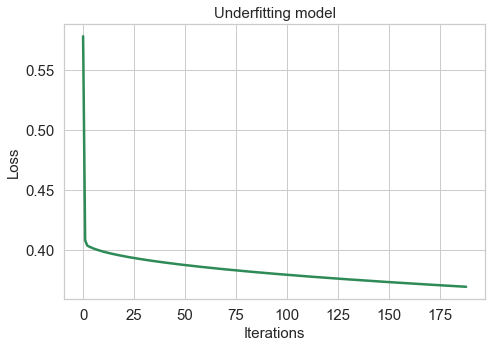

In [130]:
plt.figure(figsize=(7, 5))
plt.plot(clf.loss_curve_, color = 'seagreen', lw = 2.5)
plt.xlabel("Iterations", fontsize = 15)
plt.ylabel("Loss", fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.title("Underfitting model", fontsize=15)
plt.tight_layout()
plt.show()

In [97]:
# vediamo che il modello migliore fa delle basse performance nel training set
# cerchiamo, tra i migliori del test set, un modello che abbia delle buone performance nel training

modelli_migliori_f1 = []
i=0
for f1_test, param in primi_f1[:201]:
    print("modello {} di 200:".format(i))
    i+= 1

    clf = MLPClassifier(**param)

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_train)

    #print('Accuracy %s' % accuracy_score(y_train, y_pred))
    #print('F1-score %s' % f1_score(y_train, y_pred, average=None))
    #print(classification_report(y_train, y_pred))
    
    report = {}
    report['f1_test'] = f1_test
    report['f1_train'] = f1_score(y_train, y_pred, average=None)[1]
    report['params'] = params
    print("test {}    train {}".format(f1_test, f1_score(y_train, y_pred, average=None)[1]))
    modelli_migliori_f1.append(report)
    print(len(modelli_migliori_f1))


modello 0 di 200:
test 0.9881494986326345    train 0.7581096657335749
1
modello 1 di 200:
test 0.9851685393258427    train 0.9735747820254863
2
modello 2 di 200:
test 0.9851685393258427    train 0.9735747820254863
3
modello 3 di 200:
test 0.9851685393258427    train 0.9735747820254863
4
modello 4 di 200:
test 0.9851685393258427    train 0.9735747820254863
5
modello 5 di 200:
test 0.9851685393258427    train 0.9735747820254863
6
modello 6 di 200:
test 0.9851685393258427    train 0.9735747820254863
7
modello 7 di 200:
test 0.9851685393258427    train 0.9735747820254863
8
modello 8 di 200:
test 0.9851685393258427    train 0.9735747820254863
9
modello 9 di 200:
test 0.9851685393258427    train 0.9735747820254863
10
modello 10 di 200:
test 0.9851685393258427    train 0.9735747820254863
11
modello 11 di 200:
test 0.9851685393258427    train 0.9735747820254863
12
modello 12 di 200:
test 0.9851685393258427    train 0.9735747820254863
13
modello 13 di 200:
test 0.9847259658580414    train 0.973

C:\Users\dalla\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


test 0.9826800364630811    train 0.8584848484848484
63
modello 63 di 200:
test 0.9825190497534737    train 0.9742627345844505
64
modello 64 di 200:
test 0.9825190497534737    train 0.9742627345844505
65
modello 65 di 200:
test 0.9825190497534737    train 0.9742627345844505
66
modello 66 di 200:
test 0.9825190497534737    train 0.9742627345844505
67
modello 67 di 200:
test 0.9825190497534737    train 0.9742627345844505
68
modello 68 di 200:
test 0.9825190497534737    train 0.9742627345844505
69
modello 69 di 200:
test 0.9825190497534737    train 0.9742627345844505
70
modello 70 di 200:
test 0.9825190497534737    train 0.9742627345844505
71
modello 71 di 200:
test 0.9825190497534737    train 0.9742627345844505
72
modello 72 di 200:
test 0.9825190497534737    train 0.9742627345844505
73
modello 73 di 200:
test 0.9825190497534737    train 0.9742627345844505
74
modello 74 di 200:
test 0.9825190497534737    train 0.9742627345844505
75
modello 75 di 200:
test 0.982078853046595    train 0.9744

test 0.9816390506045679    train 0.9740016081479497
173
modello 173 di 200:
test 0.9816390506045679    train 0.9741321538667739
174
modello 174 di 200:
test 0.981199641897941    train 0.9742627345844505
175
modello 175 di 200:
test 0.981199641897941    train 0.9741321538667739
176
modello 176 di 200:
test 0.981199641897941    train 0.9748124330117899
177
modello 177 di 200:
test 0.981199641897941    train 0.9744002144484655
178
modello 178 di 200:
test 0.981199641897941    train 0.9748124330117899
179
modello 179 di 200:
test 0.981199641897941    train 0.9744002144484655
180
modello 180 di 200:
test 0.981199641897941    train 0.9748124330117899
181
modello 181 di 200:
test 0.981199641897941    train 0.9744002144484655
182
modello 182 di 200:
test 0.981199641897941    train 0.9748124330117899
183
modello 183 di 200:
test 0.981199641897941    train 0.9744002144484655
184
modello 184 di 200:
test 0.981199641897941    train 0.9748124330117899
185
modello 185 di 200:
test 0.981199641897941 

TypeError: ABCMeta object argument after ** must be a mapping, not list

In [108]:
modelli_migliori_f1.sort(key = lambda k:['f1_train'])

metrica_media = []
metrica_prodotto = []
metrica_f1 = []

for i in range(len(modelli_migliori_f1)):
    metrica_media.append( (i, ((modelli_migliori_f1[i]['f1_test'] + modelli_migliori_f1[i]['f1_train']) / 2)))
    
    metrica_prodotto.append( (i, (modelli_migliori_f1[i]['f1_test'] * modelli_migliori_f1[i]['f1_train'])))
    
    metrica_f1.append( (i, (2*(modelli_migliori_f1[i]['f1_test'] * modelli_migliori_f1[i]['f1_train']) / 
                     (modelli_migliori_f1[i]['f1_test'] + modelli_migliori_f1[i]['f1_train']))))

metrica_media.sort(key  = lambda k: k[1])
metrica_prodotto.sort(key  = lambda k: k[1])
metrica_f1.sort(key = lambda k: k[1])

for i in [198, 197]:
    print("media:    ", metrica_media[i][1], metrica_media[i][0])
    print("prodotto: ", metrica_prodotto[i][1], metrica_prodotto[i][0])
    print("f1:       ", metrica_f1[i][1], metrica_f1[i][0])

media:     0.9793716606756645 12
prodotto:  0.9591352459325241 12
f1:        0.9793373490823909 12
media:     0.9793716606756645 11
prodotto:  0.9591352459325241 11
f1:        0.9793373490823909 11


In [13]:
# modello migliore (performance ottime sia nel training che nel test set)
param = {'activation': 'identity',
         'hidden_layer_sizes': (50, 150),
         'solver': 'adam',
         'learning_rate': 'constant',
         'momentum': 0,
         'random_state': 4}

clf = MLPClassifier(max_iter=200, **param)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
print(clf.loss_)

Accuracy 0.9946498054474708
F1-score [0.99673623 0.98516854]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      5071
           1       0.97      1.00      0.99      1097

    accuracy                           0.99      6168
   macro avg       0.99      1.00      0.99      6168
weighted avg       0.99      0.99      0.99      6168

0.06565136272794658


In [132]:
#prestazioni sul training set
y_pred = clf.predict(X_train)

print('Accuracy %s' % accuracy_score(y_train, y_pred))
print('F1-score %s' % f1_score(y_train, y_pred, average=None))
print(classification_report(y_train, y_pred))
#f1 == 0.9847259658580414

Accuracy 0.9863118399110617
F1-score [0.99076375 0.97357478]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     10739
           1       0.95      0.99      0.97      3653

    accuracy                           0.99     14392
   macro avg       0.98      0.99      0.98     14392
weighted avg       0.99      0.99      0.99     14392



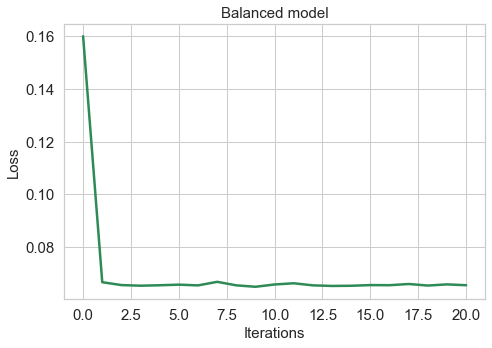

In [134]:
plt.figure(figsize=(7, 5))
plt.plot(clf.loss_curve_, color = 'seagreen', lw = 2.5)
plt.xlabel("Iterations", fontsize = 15)
plt.ylabel("Loss", fontsize = 15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.title("Balanced model", fontsize=15)
plt.tight_layout()
plt.show()

# ROC e Lift Chart

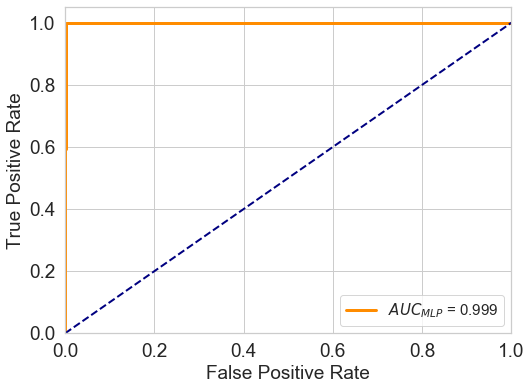

In [18]:
plt.figure(figsize = (8,6))
sns.set(style=('whitegrid'))
plt.plot(fpr, tpr, color='darkorange', lw=3, label='$AUC_{MLP}$ = %.3f' % (roc_auc))
f=19
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=f)
plt.ylabel('True Positive Rate', fontsize=f)
plt.legend(loc="lower right", fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=f)
plt.show()

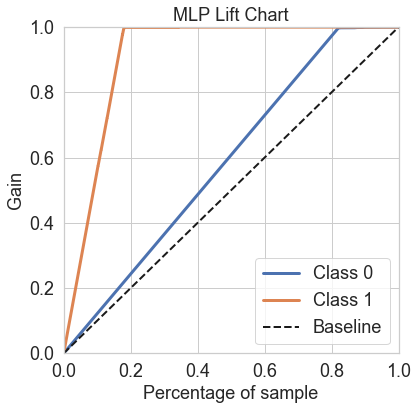

In [21]:
from scikitplot.metrics import plot_cumulative_gain

plot_cumulative_gain(y_test, y_score, title = 'MLP Lift Chart', figsize = (6,6), title_fontsize = 18, text_fontsize = 18)
